#### Compare abstract lengths between popular journals: considers condensed matter.

In [3]:
%pylab inline
import sys
sys.path.append('../')

import nltk
from nltk.corpus import stopwords

import re
import operator

s=stopwords.words('english') + ['']

# SQL
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from metadataDB.declareDatabase import *
from sqlalchemy import or_, and_

engine = create_engine("sqlite:///../arXiv_metadata.db", echo=False)
Base.metadata.bind = engine
DBsession = sessionmaker(bind=engine)
session = DBsession()

category_name = "atom-ph"

Populating the interactive namespace from numpy and matplotlib


In [4]:
#How many articles have journal references?

query = session.query(Article_Category)\
                .join(Category).join(Article)\
                .filter(Category.name.like('%'+category_name+'%'))\
                .filter(Article.journal_ref==None)
resultNone = query.all()
print len(resultNone)

query2 = session.query(Article_Category)\
                .join(Category).join(Article)\
                .filter(Category.name.like('%'+category_name+'%'))\
                .filter(Article.journal_ref!=None)
resultSome = query2.all()
print len(resultSome)



4508
4648


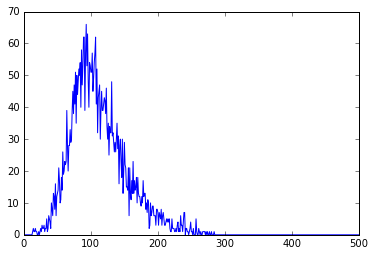

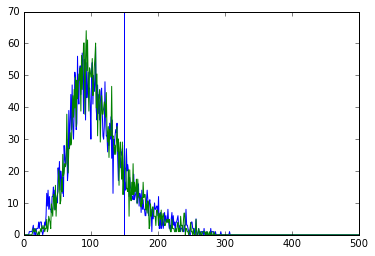

In [5]:
#Do aggregate abstract lengths from referenced vs nonreferenced articles vary?

abstract_lengths = np.zeros(5000)
too_large = 0
for item in resultSome:
    abstract = item.article.abstract
    wordnum = len(abstract.split(' '))
    if wordnum < len(abstract_lengths):
        abstract_lengths[wordnum]+=1
    else:
        too_large += 1

plot(np.arange(abstract_lengths.size),abstract_lengths)
xlim(0,500)
show()

abstract_lengths_none = np.zeros(5000)
too_large = 0
for item in resultNone:
    abstract = item.article.abstract
    wordnum = len(abstract.split(' '))
    if wordnum < len(abstract_lengths):
        abstract_lengths_none[wordnum]+=1
    else:
        too_large += 1

plot(np.arange(abstract_lengths_none.size),abstract_lengths_none,color = 'blue')
plot(np.arange(abstract_lengths.size),abstract_lengths*float(len(resultNone))/len(resultSome), color = 'green')
axvline(150)
xlim(0,500)
show()

#Answer: Not really.  

In [8]:
#What are the most common journals to the field?
query = session.query(Article_Category)\
                    .join(Category)\
                    .join(Article)\
                    .filter(Category.name.like('%'+category_name+'%'))\
                    .order_by(Article.id)
results = query.all()
journals = {}
annoying_bits = ['Al', 'vol','Vol','pp','pages', 'ue',' p',' v','no','No','ISSN','iss',' n', 'bf', 'Iss', 'Issue']
journals['None']=0
for item in results:
    jname_all = item.article.journal_ref
    if jname_all is not None:
        jname = " ".join(re.findall("[a-zA-Z]+", jname_all))
        for bit in annoying_bits:
            jname=jname.replace(bit,'')
        if jname in journals:
            journals[jname] = journals[jname]+1
        else:
            journals[jname] = 0
    else:
        journals['None'] = journals['None']+1

In [9]:
#Ok, list those popular journals.
print sorted(journals.items(),key=operator.itemgetter(1),reverse=True)

[('None', 4508), (u'Phys Rev A', 1211), (u'Phys Rev Lett', 648), (u'Physical Review A', 156), (u'New J Phys', 139), (u'J Phys B At Mol Opt Phys', 118), (u'Phys Rev A R', 98), (u'Eur Phys J D', 66), (u'Phys Rev B', 52), (u'Physical Review Letters', 50), (u'Phys Rev D', 49), (u'J Phys B', 47), (u'J Chem Phys', 44), (u'Rev Sci Instrum', 37), (u'Phys Rev C', 34), (u'Science', 28), (u'Nature', 27), (u'New Journal of Physics', 25), (u'Phys Rev A ', 25), (u'Optics Letters   ', 20), (u'Phys Rev E', 20), (u'Opt Lett', 20), (u'Al Phys B', 20), (u'Optics Express   ', 18), (u'J Phys A Math Theor', 18), (u'Al Phys Lett', 17), (u'Opt Express', 17), (u'J Phys Conf Ser', 17), (u'Physical Review A R', 16), (u'Phys Chem Chem Phys', 16), (u'European Physical Journal D', 16), (u'J Phys A', 16), (u'Optics Letters', 15), (u'PRA', 15), (u'Nature Physics', 15), (u'Europhys Lett', 14), (u'EPL', 14), (u'Optics Express', 13), (u'Phys Lett B', 13), (u'Europhysics Letters', 12), (u'PRL', 12), (u'Metrologia', 12), 

In [10]:
#These are pretty popular:
journals = [None,\
            
            ["Phys Rev Lett", "Physical Review Letters","PRL", "Phys. Rev. Lett."], \
            
            ["Phys Rev A","Physical Review A", "PRA", "Phys. Rev. A"], \
            
            ["Nature","Nat", "Nat."],\
            "Science"]    

In [12]:
#Count up how many articles are captured by above journal list.
result_by_journal=[]
for idx,j_list in enumerate(journals):
    if type(j_list) == str:
        query = session.query(Article_Category)\
                .join(Category).join(Article)\
                .filter(Category.name.like('%'+category_name+'%'))\
                .filter(Article.journal_ref.like("%"+j_list+"%"))
        result_by_journal.insert(idx,query.all())
    elif j_list == None:
        query = session.query(Article_Category)\
                .join(Category).join(Article)\
                .filter(Category.name.like('%'+category_name+'%'))\
                .filter(Article.journal_ref==None)
        result_by_journal.insert(idx,query.all())
    else:
        for k in range(len(j_list)):
            query = session.query(Article_Category)\
                .join(Category).join(Article)\
                .filter(Category.name.like('%'+category_name+'%'))\
                .filter(Article.journal_ref.like("%"+j_list[k]+"%"))
            if k==0:
                result_by_journal.insert(idx,query.all())
            else:
                result_by_journal[idx]+=query.all()
                
total_lengths = 0
for k in range(len(result_by_journal)):
    print len(result_by_journal[k])
    total_lengths += len(result_by_journal[k])
total_lengths -= len(result_by_journal[0])
print total_lengths/float(4648) #Number is total referenced articles.  Tsk tsk, hardcoding numbers.

4508
632
1478
252
50
0.518932874355


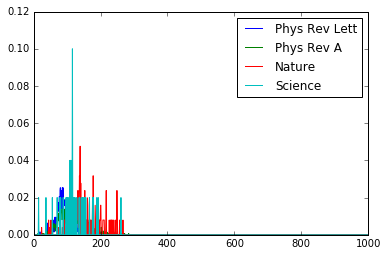

In [13]:
#Print them abstract lengths (by journal).  But ignore that one journal with 5 articles, it's the worst.  Also normalize.
too_large = 0
for idx in [1,2,3,4]:
    abstract_lengths = np.zeros(1000)
    for item in result_by_journal[idx]:
        abstract = item.article.abstract
        wordnum = len(abstract.split(' '))
        if wordnum < len(abstract_lengths):
            abstract_lengths[wordnum]+=1
        else:
            too_large += 1

    abstract_lengths /= float(len(result_by_journal[idx]))
    label = ''
    if type(journals[idx]) == str:
        jlabel = journals[idx]
    else:
        jlabel = journals[idx][0]
            
    plot(np.arange(abstract_lengths.size), abstract_lengths, label = jlabel)

legend()
show()
    
    
                         



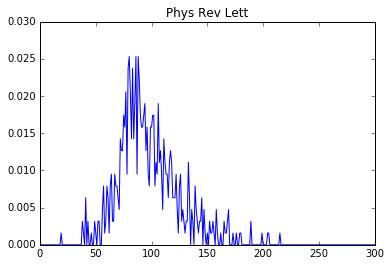

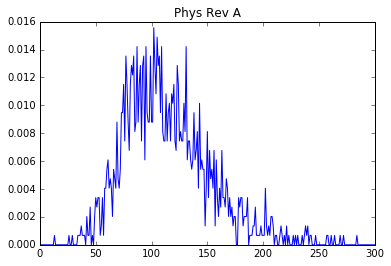

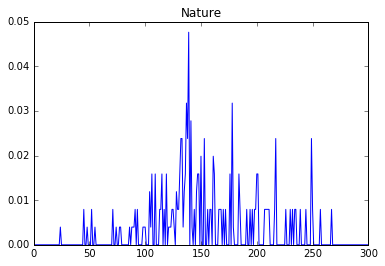

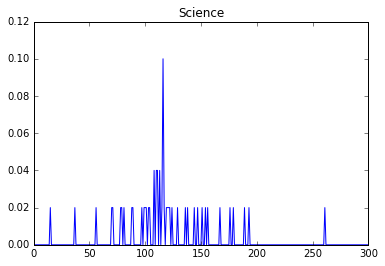

In [15]:
#Can't even with all those lines on top of each other.  Let's print them out separately.
too_large = 0
for idx in [1,2,3,4]:
    abstract_lengths = np.zeros(1000)
    for item in result_by_journal[idx]:
        abstract = item.article.abstract
        wordnum = len(abstract.split(' '))
        if wordnum < len(abstract_lengths):
            abstract_lengths[wordnum]+=1
        else:
            too_large += 1

    abstract_lengths /= float(len(result_by_journal[idx]))
    label = ''
    if type(journals[idx]) == str:
        jlabel = journals[idx]
    else:
        jlabel = journals[idx][0]
            
    plot(np.arange(abstract_lengths.size), abstract_lengths)
    title(jlabel)
    xlim(0,300)
    show()




##### So, in conclusion:
1) Abstract lengths are all probably similar.

2) Nature and phys letters have some length restrictions going on - so much so that peaks show up in the all-journal-lengths abstract plot.

3) PRL authors don't have the same abstract length requirement (?) but possibly due to page limits, abstracts are rather more terse. PRA/B/C etc are pretty qualitatively similar. The limit of writing shame is ~50 words.

1
0


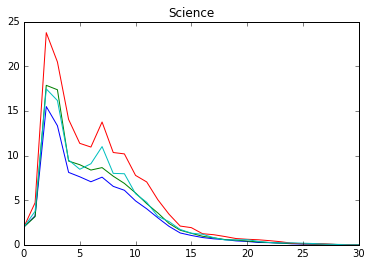

In [16]:
#Lolz, I lied.  That wasn't the end.  There's one more thing - science-y word lengths?
too_large = 0
mathword = 0
for idx in [1,2,3,4]:
    word_lengths = np.zeros(100)
    for item in result_by_journal[idx]:
        abstract = item.article.abstract
        words = abstract.split(' ')
        for el in words:
            if len(el) < len(word_lengths):
                word_lengths[len(el)]+=1
            else:
                too_large += 1
                #print el
            if el == "%$%$%":
                mathword +=1

    word_lengths /= float(len(result_by_journal[idx]))
    label = ''
    if type(journals[idx]) == str:
        jlabel = journals[idx]
    else:
        jlabel = journals[idx][0]
            
    plot(np.arange(word_lengths.size), word_lengths)
    title(jlabel)
    xlim(0,30)
print too_large
print mathword
   
 

(0, 30)

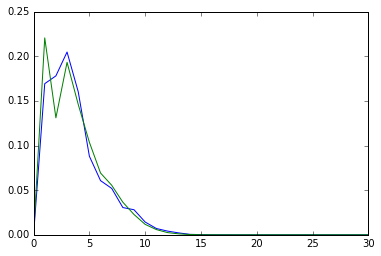

In [26]:
#Ok, but is this, like, normal?  Let's compare our typical science graph to some other human language things.

emma = nltk.corpus.gutenberg.words('austen-emma.txt')
wordlengths_emma = np.zeros(50)
leaves = nltk.corpus.gutenberg.words('whitman-leaves.txt')
wordlengths_leaves = np.zeros(50)
for el in emma:
    wordlengths_emma[len(el)]+=1
for el in leaves:
    wordlengths_leaves[len(el)]+=1
    
plot(np.arange(wordlengths_emma.size),wordlengths_emma/float(len(emma)), color = 'blue')
plot(np.arange(wordlengths_leaves.size),wordlengths_leaves/float(len(leaves)), color = 'green')
xlim(0,30)
